In [1]:
import cv2
import matplotlib.pyplot as plt
import pickle

In [3]:
# loading the model
with open('MNIST_Logistic_Regression_GPU.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
img_path = "Numbers/Numbers.png"

img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# converting to pure black and white to find edges better
_, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

digits = []
bounding_box = []

# loop through all contours and find the region
# then add 20 pixels around that border
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    digit_region = gray[y:y+h, x:x+w]
    digit_padded = cv2.copyMakeBorder(digit_region, 20, 20, 20, 20,
                                      cv2.BORDER_CONSTANT, value=255)

    digits.append(digit_padded)
    bounding_box.append((x, y, w, h))

In [5]:
preds = []
confs = []

# looping through our list and also adding an index
for i, digit_img in enumerate(digits):

    # preprocessing shit
    resize = cv2.resize(digit_img, (28, 28))
    invert = 255 - resize
    normalize = invert / 255.0
    flatten = normalize.reshape(1, -1)

    # predict processed img
    pred = model.predict(flatten)[0]
    conf = model.predict_proba(flatten)[0]

    preds.append(pred)
    confs.append(conf)

print(f"Found {len(preds)} digits")

Found 10 digits


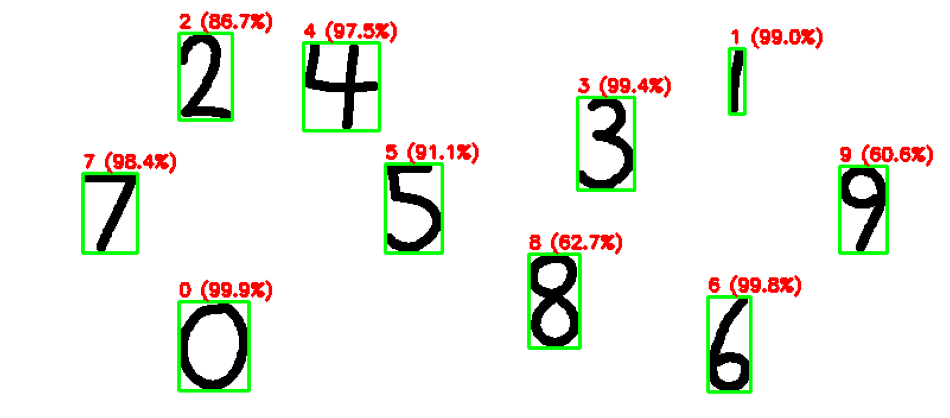

In [13]:
# copy of img to draw on
result_image = img.copy()


for i in range(len(bounding_box)):
    # get the position and size of the digit
    x, y, w, h = bounding_box[i]

    # our prediction with its confisence score
    predicted_digit = preds[i]
    confidence_score = confs[i][predicted_digit] * 100

    # green box around the digit
    cv2.rectangle(result_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # prediction text above the box
    label = f'{predicted_digit} ({confidence_score:.1f}%)'
    cv2.putText(result_image,
                label,
                (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,          # font size
                (0, 0, 255),  # color
                2)            # thickness

# Show the final image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()